# A step towards the Single Particle Model

In the [previous notebook](./2-a-pde-model.ipynb) we saw how to solve a PDE model in pybamm. Now it is time to solve a real-life battery problem! We consider the problem of spherical diffusion in the negative electrode particle within the single particle model. That is,
$$
  \frac{\partial c}{\partial t} = \nabla \cdot (D \nabla c),
$$
with the following boundary and initial conditions:
$$
  \left.\frac{\partial c}{\partial r}\right\vert_{r=0} = 0, \quad \left.\frac{\partial c}{\partial r}\right\vert_{r=R} = -\frac{j}{FD}, \quad \left.c\right\vert_{t=0} = c_0,
$$
where $c$ is the concentration, $r$ the radial coordinate, $t$ time, $R$ the particle radius, $D$ the diffusion coefficient, $j$ the interfacial current density, $F$ Faraday's constant, and $c_0$ the initial concentration. 

In this example we use the following parameters:

| Symbol | Units              | Value                                          |
|:-------|:-------------------|:-----------------------------------------------|
| $R$      | m                | $10 \times 10^{-6}$                            |
| $D$      | m${^2}$ s$^{-1}$ | $3.9 \times 10^{-14}$                          |
| $j$      | A m$^{-2}$       | $1.4$                                          |
| $F$      | C mol$^{-1}$     | $96485$                                        |
| $c_0$    | mol m$^{-3}$     | $2.5 \times 10^{4}$                            |



## Setting up the model
As before, we begin by importing the PyBaMM library into this notebook, along with any other packages we require, and start with an empty `pybamm.BaseModel`


In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import matplotlib.pyplot as plt

import pybamm

model = pybamm.BaseModel()

Note: you may need to restart the kernel to use updated packages.


We then define all of the model variables and parameters. Parameters are created using the `pybamm.Parameter` class and are given informative names (with units). Later, we will provide parameter values and the `Parameter` objects will be turned into numerical values. For more information please see the [parameter values notebook](../parameterization/parameter-values.ipynb).

In [2]:
R = pybamm.Parameter("Particle radius [m]")
D = pybamm.Parameter("Diffusion coefficient [m2.s-1]")
j = pybamm.Parameter("Interfacial current density [A.m-2]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")
c0 = pybamm.Parameter("Initial concentration [mol.m-3]")

c = pybamm.Variable("Concentration [mol.m-3]", domain="negative particle")

Now we define our model equations, boundary and initial conditions, as in the previous example. 

In [3]:
# governing equations
N = -D * pybamm.grad(c)  # flux
dcdt = -pybamm.div(N)
model.rhs = {c: dcdt}

# boundary conditions
lbc = pybamm.Scalar(0)
rbc = -j / F / D
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}}

# initial conditions
model.initial_conditions = {c: c0}

Finally, we add any variables of interest to the dictionary `model.variables`

In [4]:
model.variables = {
    "Concentration [mol.m-3]": c,
    "Surface concentration [mol.m-3]": pybamm.surf(c),
    "Flux [mol.m-2.s-1]": N,
}

## Using the model

In order to discretise and solve the model we need to provide values for all of the parameters. This is done via the `pybamm.ParameterValues` class, which accepts a dictionary of parameter names and values

In [5]:
param = pybamm.ParameterValues(
    {
        "Particle radius [m]": 10e-6,
        "Diffusion coefficient [m2.s-1]": 3.9e-14,
        "Interfacial current density [A.m-2]": 1.4,
        "Faraday constant [C.mol-1]": 96485,
        "Initial concentration [mol.m-3]": 2.5e4,
    }
)

Here all of the parameters are simply scalars, but they can also be functions or read in from data (see [parameter values notebook](../parameterization/parameter-values.ipynb)).

As in the previous example, we define the particle geometry. Note that in this example the definition of the geometry contains a parameter, the particle radius $R$

In [6]:
r = pybamm.SpatialVariable(
    "r", domain=["negative particle"], coord_sys="spherical polar"
)
geometry = {"negative particle": {r: {"min": pybamm.Scalar(0), "max": R}}}

Both the model and geometry can now be processed by the parameter class. This replaces the parameters with the values

In [7]:
param.process_model(model)
param.process_geometry(geometry)

We can now set up our mesh, choose a spatial method, and discretise our model

In [8]:
submesh_types = {"negative particle": pybamm.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

The model is now discretised and ready to be solved.

### Solving the model

As is the previous example, we choose a solver and times at which we want the solution returned.

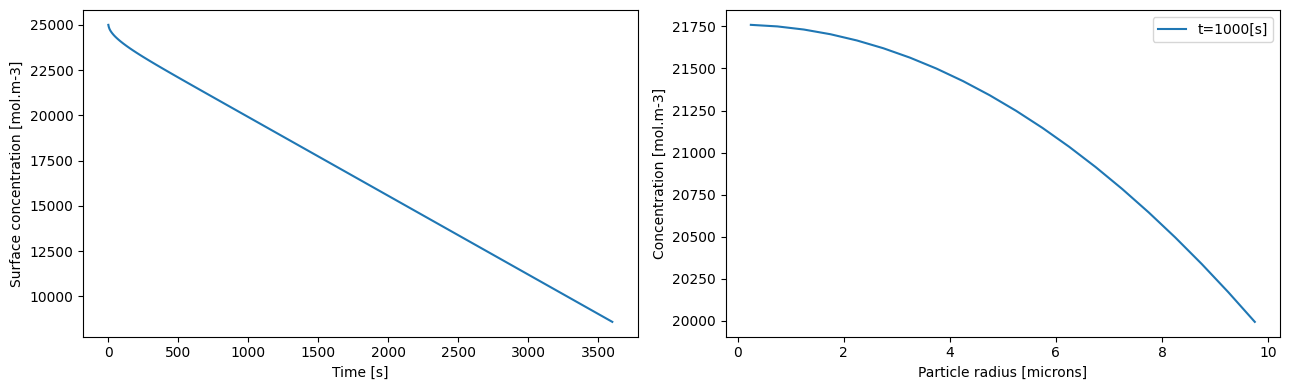

In [9]:
# solve
solver = pybamm.IDAKLUSolver()
t = [0, 3600]
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration [mol.m-3]"]
c_surf = solution["Surface concentration [mol.m-3]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c_surf(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Surface concentration [mol.m-3]")

r = mesh["negative particle"].nodes  # radial position
time = 1000  # time in seconds
ax2.plot(r * 1e6, c(t=time, r=r), label=f"t={time}[s]")
ax2.set_xlabel("Particle radius [microns]")
ax2.set_ylabel("Concentration [mol.m-3]")
ax2.legend()

plt.tight_layout()
plt.show()

In the [next notebook](./4-comparing-full-and-reduced-order-models.ipynb) we consider the limit of fast diffusion in the particle. This leads to a reduced-order model for the particle behaviour, which we compare with the full (Fickian diffusion) model. 

## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Alan C. Hindmarsh. The PVODE and IDA algorithms. Technical Report, Lawrence Livermore National Lab., CA (US), 2000. doi:10.2172/802599.
[4] Alan C. Hindmarsh, Peter N. Brown, Keith E. Grant, Steven L. Lee, Radu Serban, Dan E. Shumaker, and Carol S. Woodward. SUNDIALS: Suite of nonlinear and differential/algebraic equation solvers. ACM Transactions on Mathematical Software (TOMS), 31(3):363–396, 2005. doi:10.1145/1089014.1089020.
[5] Valentin Sulzer, Scott